In [207]:
import pandas as pd
from linearmodels.panel import PooledOLS, RandomEffects, PanelOLS
import statsmodels.api as sm
from linearmodels.panel import compare
import numpy as np
from scipy import stats
import numpy.linalg as la
from statsmodels.stats.stattools import durbin_watson
from statsmodels.graphics.tsaplots import plot_acf
import seaborn as sns


In [208]:
df = pd.read_csv('/Users/admin/Desktop/економетрика/ранити/new project 2.csv', sep = ';')
df = df.set_index(['Store_ID', 'Data'])
print(df.head(12))

                                      Store   Area  Opening_Year  \
Store_ID Data                                                      
1101.0   2021-01-01  Маркет 1101 - м. Луцьк  131,4        2012.0   
         2021-02-01  Маркет 1101 - м. Луцьк  131,4        2012.0   
         2021-03-01  Маркет 1101 - м. Луцьк  131,4        2012.0   
         2021-04-01  Маркет 1101 - м. Луцьк  131,4        2012.0   
         2021-05-01  Маркет 1101 - м. Луцьк  131,4        2012.0   
         2021-06-01  Маркет 1101 - м. Луцьк  131,4        2012.0   
         2021-07-01  Маркет 1101 - м. Луцьк  131,4        2012.0   
         2021-08-01  Маркет 1101 - м. Луцьк  131,4        2012.0   
         2021-09-01  Маркет 1101 - м. Луцьк  131,4        2012.0   
         2021-10-01  Маркет 1101 - м. Луцьк  131,4        2012.0   
         2021-11-01  Маркет 1101 - м. Луцьк  131,4        2012.0   
         2021-12-01  Маркет 1101 - м. Луцьк  131,4        2012.0   

                       Food_Service  Beverages 

In [209]:
string_to_float_columns = [
    'Area', 'Gross_Margin_Percentage_Store', 'Gross_Margin_Store',
    'Number_of_Food_Service_Units_Sold', 'Number_of_Beverages_Units_Sold',
    'Turnover_Food_Service', 'Turnover_Beverages', 'Share_in_Total_Sales_Food_Service',
    'Number_of_Receipts_Food_Service', 'Number_of_Receipts_Beverages',
    'Gross_Profit_Margin_Food_Service', 'Gross_Profit_Margin_Beverages',
    'Share_of_Food_Service_Margin_in_Total_Margin', 'Discount_Amount_Food_Service',
    'Discount_Amount_Beverages', 'Inventory_on_Market_Food_Service',
    'Inventory_on_Market_Beverages', 'Inventory_Balance_Food_Service',
    'Inventory_Balance_Beverages', 'Inventory_Turnover_Ratio_Food_Service',
    'Inventory_Turnover_Ratio_', 'GMROI_Food_Service', 'GMROI_Beverages',
    'Losses_Beverages'
]

for col in string_to_float_columns:
    df[col] = (
        df[col]
        .astype(str)
        .str.replace('Е', 'E', regex=False)
        .str.replace(',', '.', regex=False)
        .astype(float)
    )
df[string_to_float_columns].dtypes

Area                                            float64
Gross_Margin_Percentage_Store                   float64
Gross_Margin_Store                              float64
Number_of_Food_Service_Units_Sold               float64
Number_of_Beverages_Units_Sold                  float64
Turnover_Food_Service                           float64
Turnover_Beverages                              float64
Share_in_Total_Sales_Food_Service               float64
Number_of_Receipts_Food_Service                 float64
Number_of_Receipts_Beverages                    float64
Gross_Profit_Margin_Food_Service                float64
Gross_Profit_Margin_Beverages                   float64
Share_of_Food_Service_Margin_in_Total_Margin    float64
Discount_Amount_Food_Service                    float64
Discount_Amount_Beverages                       float64
Inventory_on_Market_Food_Service                float64
Inventory_on_Market_Beverages                   float64
Inventory_Balance_Food_Service                  

In [210]:
df = df.reset_index()
df['Data'] = pd.to_datetime(df['Data'], errors='coerce')
df = df.set_index(['Store_ID', 'Data'])
print(df.index.get_level_values('Data').dtype)

datetime64[ns]


In [211]:
variables_to_check_raw = [
    'Gross_Margin_Percentage_Store',
    'Number_of_Receipts_Food_Service',
    'GMROI_Food_Service',
    'Discount_Amount_Food_Service'
]

df_num = df[variables_to_check_raw].apply(pd.to_numeric, errors='coerce')
desc_stats = df_num.describe().T

desc_stats['Skewness'] = df_num.skew()
desc_stats['Log Recommended'] = desc_stats.apply(
    lambda row: (
        "Yes: data are strictly positive, right-skewed (skew > 1)" 
        if row['min'] > 0 and row['Skewness'] > 1 else
        "No: not highly skewed or contains zero/negative values"
    ), axis=1
)
desc_stats[['count', 'min', 'max', 'Skewness', 'Log Recommended']]



,count,min,max,Skewness,Log Recommended
Gross_Margin_Percentage_Store,2470.0,-0.027235,0.530954,3.508348,No: not highly skewed or contains zero/negativ...
Number_of_Receipts_Food_Service,2470.0,2.000000,38962.000000,3.168045,"Yes: data are strictly positive, right-skewed ..."
GMROI_Food_Service,2470.0,-0.004105,4.052735,2.540869,No: not highly skewed or contains zero/negativ...
Discount_Amount_Food_Service,2470.0,0.000000,61263.120000,2.183953,No: not highly skewed or contains zero/negativ...


### Null Hypothesis (H₀):
An increase in the share of Food Service within total store sales does not significantly affect store profitability.

### Alternative Hypothesis (H₁):
An increase in the share of Food Service within total store sales leads to a significant improvement in store profitability.

### Model
#### Dependent variable
Gross_Margin_Percentage_Store
#### Key independent variable
Share_in_Total_Sales_Food_Service
#### Control independent variable
- log(Receipts_Food_Service)
- GMROI_Food_Service
- Inventory_Turnover_Ratio_Food_Service
- Discount_Amount_Food_Service
- Area
- Competitor_Presence
- Office_Dummy
- School_Dummy
- Vacation_Time
- 2022_Dummy, 2023_Dummy
- February_Dummy ... December_Dummy

In [212]:
df['log_Receipts_Food_Service'] = np.log(df['Number_of_Receipts_Food_Service'].replace({0: np.nan}))
df['log_Share_in_Total_Sales_Food_Service'] = np.log(df['Share_in_Total_Sales_Food_Service'].replace({0: np.nan}))


In [213]:
fe_model = PanelOLS.from_formula(
    '''Gross_Margin_Percentage_Store ~ 
    log_Share_in_Total_Sales_Food_Service + 
    log_Receipts_Food_Service + 
    GMROI_Food_Service + 
    Inventory_Turnover_Ratio_Food_Service + 
    Discount_Amount_Food_Service + 
    2023_Dummy + February_Dummy + Murch_Dummy + April_Dummy + May_Dummy + 
    June_Dummy + July_Dummy + August_Dummy + September_Dummy + 
    October_Dummy + November_Dummy + December_Dummy''',
    data=df
)
fe_results = fe_model.fit(cov_type='robust')
print(str(fe_results.summary).replace("PanelOLS", "Fixed Effects"))

                                Fixed Effects Estimation Summary                                
Dep. Variable:     Gross_Margin_Percentage_Store   R-squared:                        0.9891
Estimator:                              Fixed Effects   R-squared (Between):              0.9902
No. Observations:                           2470   R-squared (Within):              -0.3933
Date:                           Mon, May 05 2025   R-squared (Overall):              0.9891
Time:                                   18:50:10   Log-likelihood                    5717.5
Cov. Estimator:                           Robust                                           
                                                   F-statistic:                   1.312e+04
Entities:                                     88   P-value                           0.0000
Avg Obs:                                  28.068   Distribution:                 F(17,2453)
Min Obs:                                  1.0000                      

In [214]:
from linearmodels.panel import RandomEffects

re_model = RandomEffects.from_formula(
    '''
    Gross_Margin_Percentage_Store ~ 
    Share_in_Total_Sales_Food_Service + 
    log_Receipts_Food_Service + 
    GMROI_Food_Service + 
    Inventory_Turnover_Ratio_Food_Service + 
    Discount_Amount_Food_Service + 
    Area + Competitor_Presence + Vacation_Time +
    2023_Dummy + February_Dummy + Murch_Dummy + April_Dummy + May_Dummy + 
    June_Dummy + July_Dummy + August_Dummy + September_Dummy + 
    October_Dummy + November_Dummy + December_Dummy
    ''',
    data=df
)

re_results = re_model.fit(cov_type='robust')
print(re_results.summary)


                              RandomEffects Estimation Summary                             
Dep. Variable:     Gross_Margin_Percentage_Store   R-squared:                        0.7196
Estimator:                         RandomEffects   R-squared (Between):              0.6301
No. Observations:                           2470   R-squared (Within):               0.7023
Date:                           Mon, May 05 2025   R-squared (Overall):              0.8028
Time:                                   18:50:18   Log-likelihood                    8326.6
Cov. Estimator:                           Robust                                           
                                                   F-statistic:                      330.98
Entities:                                     88   P-value                           0.0000
Avg Obs:                                  28.068   Distribution:                 F(19,2450)
Min Obs:                                  1.0000                                

In [215]:
def hausman(fe, re):
    in_both_coef = fe.params.index.intersection(re.params.index)
    b = fe.params[in_both_coef]
    B = re.params[in_both_coef]
    v_b = fe.cov.loc[in_both_coef, in_both_coef]
    v_B = re.cov.loc[in_both_coef, in_both_coef]
    diff = b - B
    stat = float(diff.T @ la.inv(v_b - v_B) @ diff)
    d_f = len(diff)
    pval = stats.chi2.sf(stat, d_f)
    return stat, d_f, pval

chi2, df_n, pval = hausman(fe_results, re_results)
print(f"Hausman chi²: {chi2:.4f}")
print(f"Degrees of freedom: {df_n}")
print(f"p-value: {pval:.4f}")

if pval < 0.05:
    print("Conclusion: Reject H₀ and Use Fixed Effects")
else:
    print("Conclusion: Fail to reject H₀ so Random Effects acceptable")

Hausman chi²: 599.7304
Degrees of freedom: 16
p-value: 0.0000
Conclusion: Reject H₀ and Use Fixed Effects


Перевірка припущень

#### No Serial Correlation (optional for inference)

Durbin-Watson: 1.4585
+ autocorr


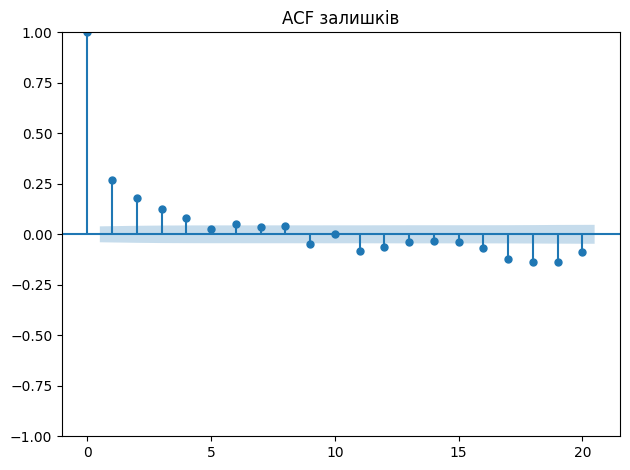

In [256]:
resid = fe_results.resids.dropna()
dw = durbin_watson(resid)
print(f"Durbin-Watson: {dw:.4f}")
if dw < 1.5:
    print("+ autocorr")
elif dw > 2.5:
    print("- autocor")
else:
    print("good")

# ACF-графік залишків
plot_acf(resid, lags=20)
plt.title("ACF залишків")
plt.tight_layout()
plt.show()


In [219]:
df['Gross_Margin_Percentage_Store_Lag1'] = df.groupby('Store_ID')['Gross_Margin_Percentage_Store'].shift(1)

In [220]:
from linearmodels.panel import PanelOLS

df_dyn = df[[
    'Gross_Margin_Percentage_Store',
    'Gross_Margin_Percentage_Store_Lag1',
    'log_Share_in_Total_Sales_Food_Service',
    'log_Receipts_Food_Service',
    'GMROI_Food_Service',
    'Inventory_Turnover_Ratio_Food_Service',
    'Discount_Amount_Food_Service',
    '2023_Dummy', 'February_Dummy', 'Murch_Dummy', 'April_Dummy', 'May_Dummy',
    'June_Dummy', 'July_Dummy', 'August_Dummy', 'September_Dummy',
    'October_Dummy', 'November_Dummy', 'December_Dummy'
]].dropna()

fe_model_lag = PanelOLS.from_formula(
    '''
    Gross_Margin_Percentage_Store ~ 
    Gross_Margin_Percentage_Store_Lag1 + 
    log_Share_in_Total_Sales_Food_Service + 
    log_Receipts_Food_Service + 
    GMROI_Food_Service + 
    Inventory_Turnover_Ratio_Food_Service + 
    Discount_Amount_Food_Service + 
    2023_Dummy + February_Dummy + Murch_Dummy + April_Dummy + May_Dummy + 
    June_Dummy + July_Dummy + August_Dummy + September_Dummy + 
    October_Dummy + November_Dummy + December_Dummy + 
    EntityEffects
    ''',
    data=df_dyn
)

fe_results_lag = fe_model_lag.fit(cov_type='robust')
print(fe_results_lag.summary)


                                PanelOLS Estimation Summary                                
Dep. Variable:     Gross_Margin_Percentage_Store   R-squared:                        0.7228
Estimator:                              PanelOLS   R-squared (Between):              0.7658
No. Observations:                           2382   R-squared (Within):               0.7228
Date:                           Mon, May 05 2025   R-squared (Overall):              0.7648
Time:                                   18:50:54   Log-likelihood                    8675.3
Cov. Estimator:                           Robust                                           
                                                   F-statistic:                      330.38
Entities:                                     83   P-value                           0.0000
Avg Obs:                                  28.699   Distribution:                 F(18,2281)
Min Obs:                                  1.0000                                

Durbin-Watson (динамічна модель): 1.3101
+


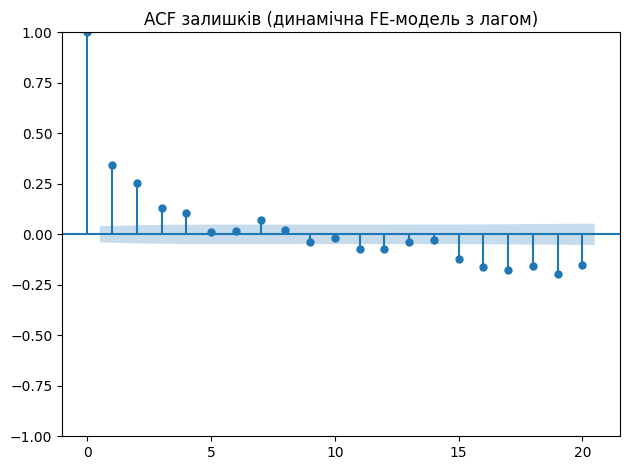

In [258]:
from statsmodels.stats.stattools import durbin_watson
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

residuals_lag = fe_results_lag.resids.dropna()

dw_lag = durbin_watson(residuals_lag)
print(f"Durbin-Watson (динамічна модель): {dw_lag:.4f}")
if dw_lag < 1.5:
    print("+")
elif dw_lag > 2.5:
    print("-")
else:
    print("Good")

plot_acf(residuals_lag, lags=20)
plt.title("ACF залишків (динамічна FE-модель з лагом)")
plt.tight_layout()
plt.show()


In [ ]:

df['Gross_Margin_Percentage_Store_Lag2'] = df.groupby('Store_ID')['Gross_Margin_Percentage_Store'].shift(2)

df_dyn2 = df[[
    'Gross_Margin_Percentage_Store',
    'Gross_Margin_Percentage_Store_Lag1',
    'Gross_Margin_Percentage_Store_Lag2',
    'log_Share_in_Total_Sales_Food_Service',
    'log_Receipts_Food_Service',
    'GMROI_Food_Service',
    'Inventory_Turnover_Ratio_Food_Service',
    'Discount_Amount_Food_Service',
    '2023_Dummy', 'February_Dummy', 'Murch_Dummy', 'April_Dummy', 'May_Dummy',
    'June_Dummy', 'July_Dummy', 'August_Dummy', 'September_Dummy',
    'October_Dummy', 'November_Dummy', 'December_Dummy'
]].dropna()

fe_model_ar2 = PanelOLS.from_formula(
    '''
    Gross_Margin_Percentage_Store ~ 
    Gross_Margin_Percentage_Store_Lag1 + 
    Gross_Margin_Percentage_Store_Lag2 + 
    log_Share_in_Total_Sales_Food_Service + 
    log_Receipts_Food_Service + 
    GMROI_Food_Service + 
    Inventory_Turnover_Ratio_Food_Service + 
    Discount_Amount_Food_Service + 
    2023_Dummy + February_Dummy + Murch_Dummy + April_Dummy + May_Dummy + 
    June_Dummy + July_Dummy + August_Dummy + September_Dummy + 
    October_Dummy + November_Dummy + December_Dummy + 
    EntityEffects
    ''',
    data=df_dyn2
)

fe_results_ar2 = fe_model_ar2.fit(cov_type='robust')
print(fe_results_ar2.summary)


                                PanelOLS Estimation Summary                                
Dep. Variable:     Gross_Margin_Percentage_Store   R-squared:                        0.7712
Estimator:                              PanelOLS   R-squared (Between):              0.8770
No. Observations:                           2299   R-squared (Within):               0.7712
Date:                           Mon, May 05 2025   R-squared (Overall):              0.8758
Time:                                   18:51:04   Log-likelihood                    8637.7
Cov. Estimator:                           Robust                                           
                                                   F-statistic:                      390.20
Entities:                                     81   P-value                           0.0000
Avg Obs:                                  28.383   Distribution:                 F(19,2199)
Min Obs:                                  2.0000                                

Durbin-Watson (AR(2) модель): 1.7192
good


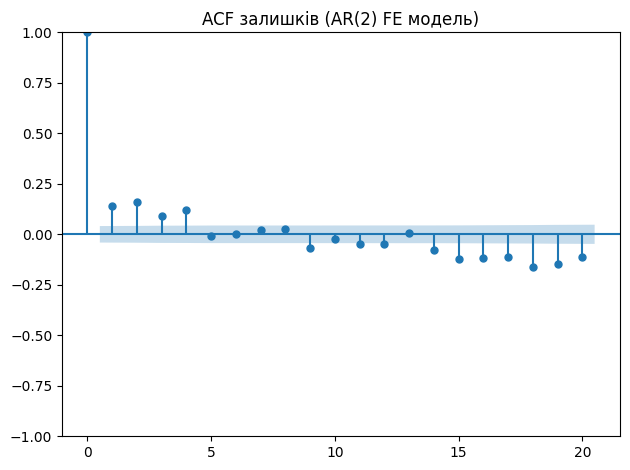

In [260]:
from statsmodels.stats.stattools import durbin_watson
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

residuals_ar2 = fe_results_ar2.resids.dropna()

dw_ar2 = durbin_watson(residuals_ar2)
print(f"Durbin-Watson (AR(2) модель): {dw_ar2:.4f}")
if dw_ar2 < 1.5:
    print("+")
elif dw_ar2 > 2.5:
    print("-")
else:
    print("good")

plot_acf(residuals_ar2, lags=20)
plt.title("ACF залишків (AR(2) FE модель)")
plt.tight_layout()
plt.show()


In [261]:
from linearmodels.panel import PanelOLS

# Побудова моделі
fe_model_final = PanelOLS.from_formula(
    '''
    Gross_Margin_Percentage_Store ~ 
    Gross_Margin_Percentage_Store_Lag1 + 
    Gross_Margin_Percentage_Store_Lag2 + 
    log_Share_in_Total_Sales_Food_Service + 
    log_Receipts_Food_Service + 
    GMROI_Food_Service + 
    Inventory_Turnover_Ratio_Food_Service + 
    Discount_Amount_Food_Service + 
    2023_Dummy + February_Dummy + Murch_Dummy + April_Dummy + May_Dummy +
    June_Dummy + July_Dummy + August_Dummy + September_Dummy +
    October_Dummy + November_Dummy + December_Dummy + 
    EntityEffects
    ''',
    data=df_dyn2
)

# Оцінка з кластеризованими похибками по Store_ID
fe_results_final = fe_model_final.fit(cov_type='clustered', cluster_entity=True)

# Вивід результату
print(fe_results_final.summary)


                                PanelOLS Estimation Summary                                
Dep. Variable:     Gross_Margin_Percentage_Store   R-squared:                        0.7712
Estimator:                              PanelOLS   R-squared (Between):              0.8770
No. Observations:                           2299   R-squared (Within):               0.7712
Date:                           Mon, May 05 2025   R-squared (Overall):              0.8758
Time:                                   20:11:03   Log-likelihood                    8637.7
Cov. Estimator:                        Clustered                                           
                                                   F-statistic:                      390.20
Entities:                                     81   P-value                           0.0000
Avg Obs:                                  28.383   Distribution:                 F(19,2199)
Min Obs:                                  2.0000                                

### No Perfect Multicollinearity (FE.2)

No regressor should be perfectly collinear with another or with the entity fixed effect.
This is why time-invariant variables (e.g., gender, location) drop out in FE.


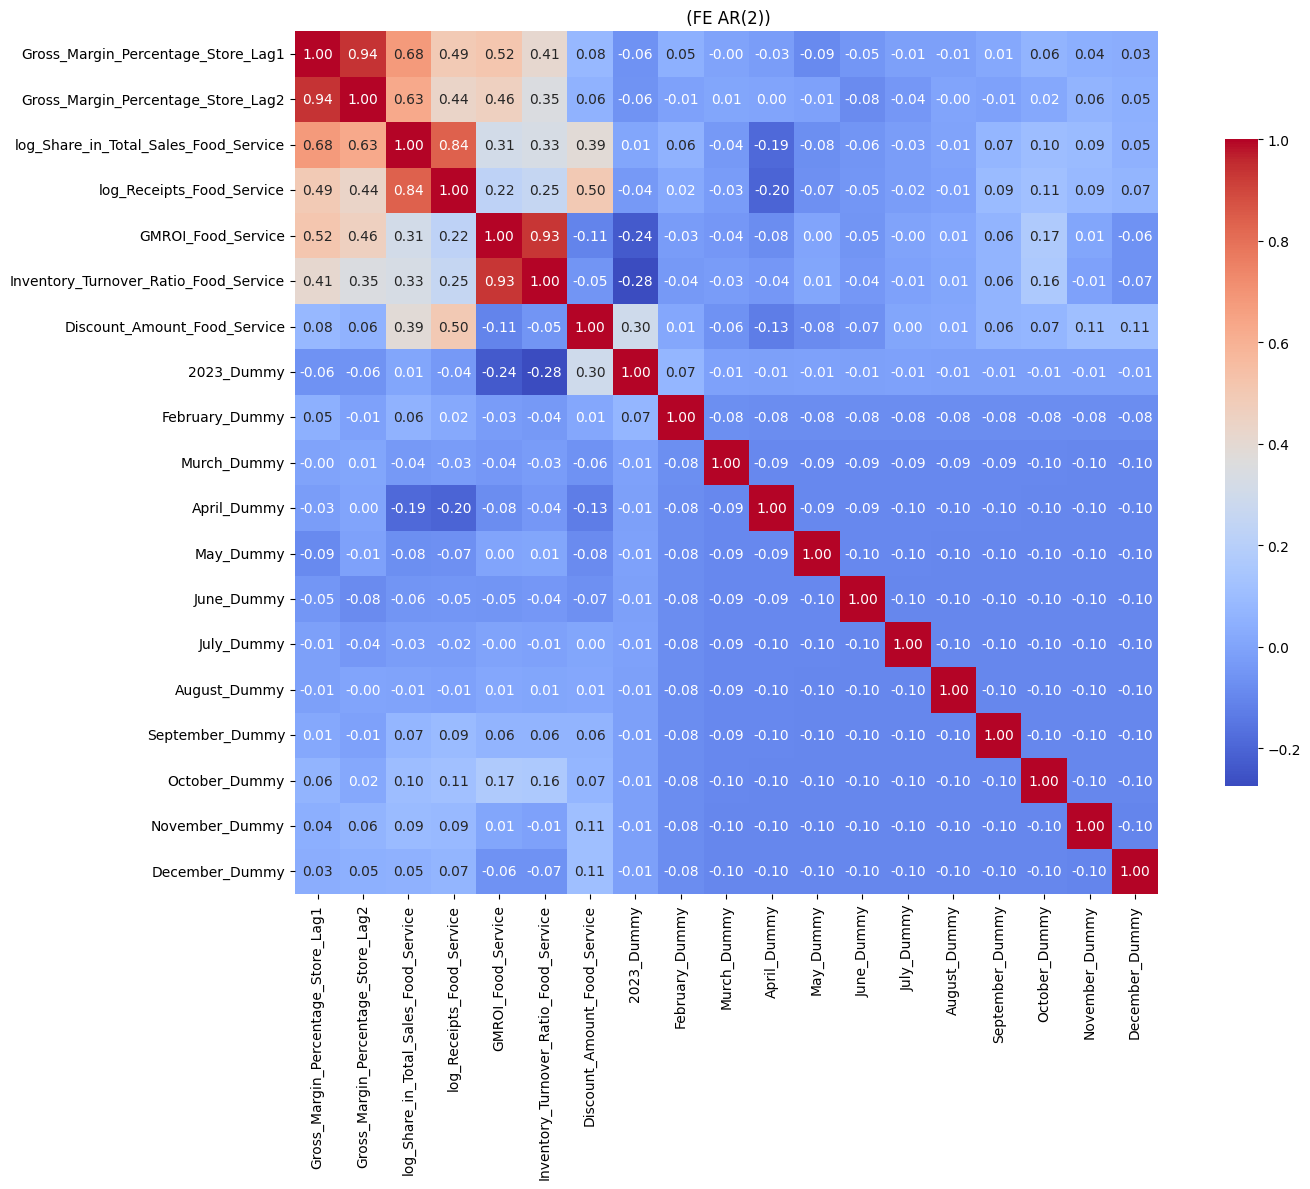

In [262]:
import seaborn as sns
import matplotlib.pyplot as plt

corr_vars = df_dyn2.drop(columns=['Gross_Margin_Percentage_Store'])
corr_matrix = corr_vars.corr()

plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True, cbar_kws={"shrink": 0.75})
plt.title(" (FE AR(2))")
plt.tight_layout()
plt.show()


In [263]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

X_vif = df_dyn2.drop(columns=['Gross_Margin_Percentage_Store'])
X_vif = sm.add_constant(X_vif)

vif_data = pd.DataFrame()
vif_data["Variable"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]

vif_data


,Variable,VIF
0,const,1226.358381
1,Gross_Margin_Percentage_Store_Lag1,11.201863
2,Gross_Margin_Percentage_Store_Lag2,9.384491
3,log_Share_in_Total_Sales_Food_Service,5.503849
4,log_Receipts_Food_Service,4.108801
5,GMROI_Food_Service,12.187630
6,Inventory_Turnover_Ratio_Food_Service,10.772867
7,Discount_Amount_Food_Service,1.702250
8,2023_Dummy,1.281537
9,February_Dummy,1.966695


In [ ]:

df['Margin_x_Turnover'] = df['Gross_Profit_Margin_Food_Service'] * df['Inventory_Turnover_Ratio_Food_Service']


df_dyn2_inter = df[[
    'Gross_Margin_Percentage_Store',
    'Gross_Margin_Percentage_Store_Lag1',
    'Gross_Margin_Percentage_Store_Lag2',
    'Share_in_Total_Sales_Food_Service',
    'log_Receipts_Food_Service',
    'Gross_Profit_Margin_Food_Service',
    'Inventory_Turnover_Ratio_Food_Service',
    'Margin_x_Turnover',
    'Discount_Amount_Food_Service', '2022_Dummy',
    '2023_Dummy', 'February_Dummy', 'Murch_Dummy', 'April_Dummy', 'May_Dummy',
    'June_Dummy', 'July_Dummy', 'August_Dummy', 'September_Dummy',
    'October_Dummy', 'November_Dummy', 'December_Dummy'
]].dropna()


In [264]:
from linearmodels.panel import PanelOLS

fe_model_final = PanelOLS.from_formula(
    '''
    Gross_Margin_Percentage_Store ~ 
    Gross_Margin_Percentage_Store_Lag1 + 
    Gross_Margin_Percentage_Store_Lag2 + 
    Share_in_Total_Sales_Food_Service + 
    log_Receipts_Food_Service + 
    Gross_Profit_Margin_Food_Service + 
    Inventory_Turnover_Ratio_Food_Service + 
    Margin_x_Turnover + 
    Discount_Amount_Food_Service + 
    2023_Dummy + February_Dummy + Murch_Dummy + April_Dummy + May_Dummy +
    June_Dummy + July_Dummy + August_Dummy + September_Dummy +
    October_Dummy + November_Dummy + December_Dummy + 
    EntityEffects
    ''',
    data=df_dyn2_inter
)

fe_results_final = fe_model_final.fit(cov_type='clustered', cluster_entity=True)
print(fe_results_final.summary)


                                PanelOLS Estimation Summary                                
Dep. Variable:     Gross_Margin_Percentage_Store   R-squared:                        0.8159
Estimator:                              PanelOLS   R-squared (Between):              0.9055
No. Observations:                           2299   R-squared (Within):               0.8159
Date:                           Mon, May 05 2025   R-squared (Overall):              0.9030
Time:                                   20:12:05   Log-likelihood                    8887.4
Cov. Estimator:                        Clustered                                           
                                                   F-statistic:                      487.11
Entities:                                     81   P-value                           0.0000
Avg Obs:                                  28.383   Distribution:                 F(20,2198)
Min Obs:                                  2.0000                                

In [265]:
from linearmodels.panel import PanelOLS

fe_model_final_opt = PanelOLS.from_formula(
    '''
    Gross_Margin_Percentage_Store ~ 
    Gross_Margin_Percentage_Store_Lag1 +
    Share_in_Total_Sales_Food_Service + 
    log_Receipts_Food_Service + 
    Inventory_Turnover_Ratio_Food_Service + 
    Margin_x_Turnover + 
    Discount_Amount_Food_Service + 2023_Dummy + 2022_Dummy +
    February_Dummy + Murch_Dummy + April_Dummy + May_Dummy +
    June_Dummy + July_Dummy + August_Dummy + September_Dummy +
    October_Dummy + November_Dummy + December_Dummy + 
    EntityEffects
    ''',
    data=df_dyn2_inter
)

fe_results_final_opt = fe_model_final_opt.fit(cov_type='clustered', cluster_entity=True)
print(fe_results_final_opt.summary)


                                PanelOLS Estimation Summary                                
Dep. Variable:     Gross_Margin_Percentage_Store   R-squared:                        0.8260
Estimator:                              PanelOLS   R-squared (Between):              0.8895
No. Observations:                           2299   R-squared (Within):               0.8260
Date:                           Mon, May 05 2025   R-squared (Overall):              0.8865
Time:                                   20:12:08   Log-likelihood                    8952.2
Cov. Estimator:                        Clustered                                           
                                                   F-statistic:                      549.43
Entities:                                     81   P-value                           0.0000
Avg Obs:                                  28.383   Distribution:                 F(19,2199)
Min Obs:                                  2.0000                                

### final

Durbin-Watson: 1.5657


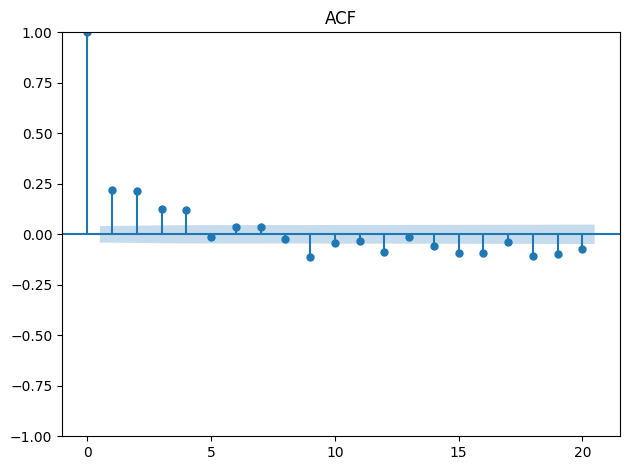

In [266]:
from statsmodels.stats.stattools import durbin_watson
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

resid = fe_results_final_opt.resids.dropna()

# Durbin-Watson
print(f"Durbin-Watson: {durbin_watson(resid):.4f}")

# ACF
plot_acf(resid, lags=20)
plt.title("ACF")
plt.tight_layout()
plt.show()


In [267]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

vif = pd.DataFrame()
vif["Variable"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif)


AttributeError: 'PanelData' object has no attribute 'columns'